<a href="https://colab.research.google.com/github/saquib9790/proj2_hci/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, random, math, itertools
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

IMG_HEIGHT, IMG_WIDTH = 64, 256
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [2]:
from huggingface_hub import snapshot_download
import zipfile

dataset_dir = snapshot_download(
  repo_id="YCAI3/HCI_P2",
  repo_type="dataset",
  local_dir="./HCI_Dataset",
  ignore_patterns=[".gitattributes"]
)

print("Dataset downloaded to:", dataset_dir)

zip_path = os.path.join(dataset_dir, "HCI_Dataset.zip")
extract_dir = os.path.join(dataset_dir, "unzipped")

# Extract the dataset if not already extracted
if not os.path.exists(extract_dir):
  with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

# Base path where the actual images live
base_path = "./HCI_Dataset/unzipped/HCI_Dataset"
assert os.path.exists(base_path), f"Expected folder not found: {base_path}"


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

HCI_Dataset.zip:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/971 [00:00<?, ?B/s]

Dataset downloaded to: /content/HCI_Dataset


In [3]:
# Recursively collect *.jpg
image_paths = glob(os.path.join(base_path, "**", "*.jpg"), recursive=True)
print("Total images found:", len(image_paths))

def get_word_label_from_filename(path):
  fname = os.path.basename(path)
  parts = fname.split("_")
  return parts[1] if len(parts) >= 2 else ""

data = pd.DataFrame({
  "path": image_paths,
  "label": [get_word_label_from_filename(p) for p in image_paths]
})

# Basic sanity check
print(data.sample(5))
print("Unique sample words:", data['label'].nunique())


Total images found: 609656
                                                     path      label
497818  ./HCI_Dataset/unzipped/HCI_Dataset/142/6/128_S...   SNORTING
180397  ./HCI_Dataset/unzipped/HCI_Dataset/16/6/250_OA...     OAXACA
232696  ./HCI_Dataset/unzipped/HCI_Dataset/80/1/368_BR...  BRITISHER
19774   ./HCI_Dataset/unzipped/HCI_Dataset/27/5/298_HO...  HOODOOING
244604  ./HCI_Dataset/unzipped/HCI_Dataset/72/6/180_Be...  Bedizened
Unique sample words: 237485


In [4]:
all_text = "".join(data["label"].astype(str).tolist())
unique_chars = sorted(list(set(all_text)))
print("Unique chars ({}):".format(len(unique_chars)), unique_chars[:80], "...")

char_to_num = layers.StringLookup(
  vocabulary=unique_chars,
  num_oov_indices=0,
  mask_token=None
)

num_to_char = layers.StringLookup(
  vocabulary=char_to_num.get_vocabulary(),
  invert=True,
  num_oov_indices=0,
  mask_token=None
)

test_word = data["label"].iloc[0]
enc = char_to_num(tf.strings.unicode_split(test_word, "UTF-8"))
dec = tf.strings.reduce_join(num_to_char(enc)).numpy().decode("utf-8")
print("Test label:", test_word, "| Encoded len:", enc.shape[0], "| Decoded:", dec)


Unique chars (62): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] ...
Test label: undismayed | Encoded len: 10 | Decoded: undismayed


In [5]:
def safe_read_jpeg(path):
    img_bytes = tf.io.read_file(path)

    def _decode():
        return tf.image.decode_jpeg(img_bytes, channels=1)

    def _dummy():
        return tf.zeros([IMG_HEIGHT, IMG_WIDTH, 1], dtype=tf.uint8)

    return tf.cond(
        tf.size(img_bytes) > 0,
        _decode,
        _dummy
    )

def preprocess_example(path, label_str):
    img = safe_read_jpeg(path)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0

    label_chars = tf.strings.unicode_split(label_str, "UTF-8")
    label_ids = char_to_num(label_chars)
    return img, label_ids


In [6]:
idx = np.arange(len(data))
np.random.shuffle(idx)

train_end = int(0.8 * len(idx))
val_end   = int(0.9 * len(idx))

train_idx = idx[:train_end]
val_idx   = idx[train_end:val_end]
test_idx  = idx[val_end:]

train_paths = data["path"].values[train_idx]
train_labels= data["label"].values[train_idx]
val_paths   = data["path"].values[val_idx]
val_labels  = data["label"].values[val_idx]
test_paths  = data["path"].values[test_idx]
test_labels = data["label"].values[test_idx]

print("Splits -> train:", len(train_paths), "val:", len(val_paths), "test:", len(test_paths))

train_raw = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_raw   = tf.data.Dataset.from_tensor_slices((val_paths,   val_labels))
test_raw  = tf.data.Dataset.from_tensor_slices((test_paths,  test_labels))

train_mapped = train_raw.map(preprocess_example, num_parallel_calls=AUTOTUNE)
val_mapped   = val_raw.map(preprocess_example,   num_parallel_calls=AUTOTUNE)
test_mapped  = test_raw.map(preprocess_example,  num_parallel_calls=AUTOTUNE)


Splits -> train: 487724 val: 60966 test: 60966


In [7]:
def _to_dtypes(img, label_ids):
    return tf.cast(img, tf.float32), tf.cast(label_ids, tf.int32)

train_mapped = train_mapped.map(_to_dtypes, num_parallel_calls=AUTOTUNE)
val_mapped   = val_mapped.map(_to_dtypes,   num_parallel_calls=AUTOTUNE)
test_mapped  = test_mapped.map(_to_dtypes,  num_parallel_calls=AUTOTUNE)

PADDING_VALUES = (
    tf.constant(0.0, dtype=tf.float32),
    tf.constant(-1,   dtype=tf.int32)
)

train_ds = (
    train_mapped
    .shuffle(20000)
    .padded_batch(
        BATCH_SIZE,
        padded_shapes=([IMG_HEIGHT, IMG_WIDTH, 1], [None]),
        padding_values=PADDING_VALUES
    )
    .repeat()           # <<< CRITICAL FIX
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_mapped
    .padded_batch(
        BATCH_SIZE,
        padded_shapes=([IMG_HEIGHT, IMG_WIDTH, 1], [None]),
        padding_values=PADDING_VALUES
    )
    .repeat()
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_mapped
    .padded_batch(
        BATCH_SIZE,
        padded_shapes=([IMG_HEIGHT, IMG_WIDTH, 1], [None]),
        padding_values=PADDING_VALUES
    )
    .prefetch(AUTOTUNE)
)

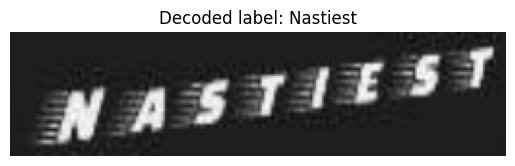

In [8]:
def decode_label_ids(label_ids_tensor):
  valid = tf.boolean_mask(label_ids_tensor, label_ids_tensor != -1)
  chars = num_to_char(valid)
  return tf.strings.reduce_join(chars).numpy().decode("utf-8")

import matplotlib.pyplot as plt

for imgs, labs in train_ds.take(1):
  idx = 0
  plt.imshow(tf.squeeze(imgs[idx]), cmap='gray')
  plt.title("Decoded label: " + decode_label_ids(labs[idx]))
  plt.axis('off')
  plt.show()
  break


In [40]:
def ctc_loss_func(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)

    B = tf.shape(y_true)[0]
    T = tf.shape(y_pred)[1]

    label_len = tf.reduce_sum(tf.cast(y_true != -1, tf.int32), axis=1)
    label_len = tf.minimum(label_len, T)

    y_true_fixed = tf.where(y_true < 0, 0, y_true)

    return keras.backend.ctc_batch_cost(
        y_true_fixed,
        y_pred,
        tf.fill([B, 1], T),
        tf.reshape(label_len, [B, 1])
    )


In [41]:
from tensorflow.keras import layers, models

def build_crnn_lstm(img_h=IMG_HEIGHT, img_w=IMG_WIDTH, vocab_size=None):
    assert vocab_size is not None

    inp = layers.Input(shape=(img_h, img_w, 1))

    x = layers.RandomContrast(0.2)(inp)
    x = layers.RandomBrightness(0.2)(x)

    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,1))(x)

    x = layers.Dropout(0.25)(x)

    # ⭐ FINAL FIX: TimeDistributed Flatten
    x = layers.Permute((2,1,3))(x)  # => (batch, time, hp, c)
    x = layers.TimeDistributed(layers.Flatten())(x)  # => (batch, time, hp*c)

    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

    outputs = layers.Dense(vocab_size, activation="softmax")(x)
    return models.Model(inputs=inp, outputs=outputs)


In [42]:
VOCAB_SIZE = len(unique_chars) + 1
crnn_lstm = build_crnn_lstm(vocab_size=VOCAB_SIZE)

In [43]:
imgs, labs = next(iter(train_ds))
print("Batch images:", imgs.shape, imgs.dtype)
print("Batch labels:", labs.shape, labs.dtype)

probe = crnn_lstm(imgs[:1])
print("Model output shape (B, T, C):", probe.shape)


Batch images: (32, 64, 256, 1) <dtype: 'float32'>
Batch labels: (32, 13) <dtype: 'int32'>
Model output shape (B, T, C): (1, 64, 63)


In [44]:
SUB_TRAIN = 200000
SUB_VAL   = 40000

subset_train = (
    train_ds.unbatch().take(SUB_TRAIN).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
)
subset_val = (
    val_ds.unbatch().take(SUB_VAL).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
)

steps_per_epoch = SUB_TRAIN // BATCH_SIZE
validation_steps = SUB_VAL // BATCH_SIZE

crnn_lstm.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=ctc_loss_func
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
]

history_lstm_adam = crnn_lstm.fit(
    subset_train,
    validation_data=subset_val,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 263s 41ms/step - loss: 33.7557 - val_loss: 29.7957
Epoch 2/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 255s 41ms/step - loss: 29.6230 - val_loss: 29.5374
Epoch 3/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 255s 41ms/step - loss: 29.4571 - val_loss: 29.4663
Epoch 4/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 255s 41ms/step - loss: 29.3900 - val_loss: 29.3050
Epoch 5/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 256s 41ms/step - loss: 29.0693 - val_loss: 27.4415
Epoch 6/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 255s 41ms/step - loss: 28.0514 - val_loss: 25.4856
Epoch 7/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 254s 41ms/step - loss: 27.1112 - val_loss: 24.5342
Epoch 8/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 254s 41ms/step - loss: 26.6043 - val_loss: 23.5048
Epoch 9/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 253s 41ms/step - loss: 26.0901 - val_loss: 22.1590
Epoch 10/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 253s 41ms/step - loss: 25.3487 - val_loss: 20.3023
Epoch 11/50
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 254s 41ms/step - loss: 24.

In [45]:
best_val = min(history_lstm_adam.history['val_loss'])
print(f"Best val_loss: {best_val:.4f}")


Best val_loss: 2.9906


In [46]:
import json

crnn_lstm.save("crnn_lstm_adam.keras")

with open("vocab.json", "w") as f:
  json.dump(unique_chars, f)

with open ("history_lstm_adam.json", "w") as f:
  json.dump(history_lstm_adam.history, f)


In [50]:
def evaluate_accuracy(model, dataset, max_batches=None):
    total = 0
    correct = 0

    for batch_i, (imgs, labs) in enumerate(dataset):

        # Forward pass
        preds = model(imgs)
        batch_size = tf.shape(preds)[0]
        T = tf.shape(preds)[1]

        input_len = tf.fill([batch_size], T)
        decoded, _ = keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)
        decoded_out = decoded[0]

        # ---- FIX: Convert decoded output to dense array safely ----
        if isinstance(decoded_out, tf.SparseTensor):
            dense = tf.sparse.to_dense(decoded_out, default_value=-1)
        elif isinstance(decoded_out, tf.RaggedTensor):
            dense = decoded_out.to_tensor(default_value=-1)
        else:
            dense = decoded_out  # Already dense

        dense = dense.numpy()
        labs = labs.numpy()
        # -----------------------------------------------------------

        for p, t in zip(dense, labs):

            # Remove -1 padding
            p = p[p != -1]
            t = t[t != -1]

            # Convert to chars
            pred_chars = num_to_char(tf.constant(p, dtype=tf.int64))
            true_chars = num_to_char(tf.constant(t, dtype=tf.int64))

            pred_str = b"".join(pred_chars.numpy()).decode()
            true_str = b"".join(true_chars.numpy()).decode()

            if pred_str == true_str:
                correct += 1

            total += 1

        if max_batches is not None and batch_i >= max_batches:
            break

    return correct / total


In [53]:
acc = evaluate_accuracy(crnn_lstm, test_ds)
print("Word-level accuracy:", acc)


Word-level accuracy: 0.36120132532887184


In [54]:
import json

with open("vocab.json", "r") as f:
  vocab = json.load(f)

char_to_num = layers.StringLookup(
  vocabulary=vocab,
  num_oov_indices=0,
  mask_token=None
)
num_to_char = layers.StringLookup(
  vocabulary=char_to_num.get_vocabulary(),
  invert=True,
  num_oov_indices=0,
  mask_token=None
)
# The CTC blank is the last index by construction (len(vocab))
blank_index = len(vocab)

inference_model = keras.models.load_model("crnn_lstm_adam.keras", compile=False)

In [55]:
from google.colab import files

print("Please upload the video file you want to process:")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f'User uploaded file "{filename}"')
    # You can now use 'filename' to refer to the uploaded file,
    # for example, by setting input_video_path = filename in the next cell.

Please upload the video file you want to process:


Saving my_test_video (2).mp4 to my_test_video (2).mp4
User uploaded file "my_test_video (2).mp4"


In [66]:
# === Ultra-minimal CRNN video recognizer (Stabilized Predictions + Band Crop) ===
import os, json, itertools
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque, Counter  # <<< NEW: stability buffer

# --- paths (edit if needed) ---
MODEL_PATH   = "crnn_lstm_adam.keras"
VOCAB_PATH   = "vocab.json"
INPUT_VIDEO  = "my_test_video.mp4"
OUTPUT_VIDEO = "output_video_adam.mp4"

# --- must match training ---
IMG_HEIGHT, IMG_WIDTH = 64, 256

# --- runtime knobs ---
BAND_FRAC     = 0.38   # center horizontal band
FRAME_STRIDE  = 2       # process every Nth frame

# --- load model + vocab ---
model = keras.models.load_model(MODEL_PATH, compile=False)
with open(VOCAB_PATH, "r") as f:
    unique_chars = json.load(f)

char_to_num = layers.StringLookup(vocabulary=unique_chars, num_oov_indices=0, mask_token=None)
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    invert=True,
    num_oov_indices=0,
    mask_token=None
)

BLANK = len(unique_chars)

print(f"Loaded model: {model.name} | vocab={len(unique_chars)} | blank={BLANK}")

# --- greedy decoder ---
def greedy_decode(pred, blank_index=len(unique_chars)):
    idx = np.argmax(pred[0], axis=-1)
    collapsed = [k for k,_ in itertools.groupby(idx)]
    kept = [i for i in collapsed if i != blank_index]
    if not kept:
        return ""
    chars = num_to_char(tf.constant(kept))
    return tf.strings.reduce_join(chars).numpy().decode("utf-8")

# --- crop band ---
def crop_center_band(gray, band_frac=BAND_FRAC):
    H, W = gray.shape
    band_h = max(30, int(H * band_frac))
    y0 = (H - band_h) // 2
    return gray[y0:y0+band_h, :], (0, y0, W, band_h)

# --- preprocess for model ---
def to_batch(img_gray):
    # invert only if background is very dark
    if img_gray.mean() < 115:
        img_gray = cv2.bitwise_not(img_gray)

    img = cv2.resize(img_gray, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LINEAR)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, -1)      # (H, W, 1)
    return np.expand_dims(img, 0)      # (1, H, W, 1)

# === NEW: prediction stability buffer ===
pred_buffer = deque(maxlen=5)  # stores last 5 predictions

# --- video I/O ---
cap = cv2.VideoCapture(INPUT_VIDEO)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open {INPUT_VIDEO}")

W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) or 24

writer = cv2.VideoWriter(
    OUTPUT_VIDEO,
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (W, H)
)

print(f"Processing {INPUT_VIDEO} → {OUTPUT_VIDEO} ...")

last_text = ""
frame_idx = 0

# --- main loop ---
while True:
    ok, frame = cap.read()
    if not ok:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    band, (x, y, w, h) = crop_center_band(gray, band_frac=BAND_FRAC)

    if frame_idx % FRAME_STRIDE == 0:
        batch = to_batch(band)
        y_pred = model.predict(batch, verbose=0)
        text = greedy_decode(y_pred, blank_index=BLANK)

        # Add every prediction (even empty) to buffer
        pred_buffer.append(text)

        # Most common non-empty prediction in buffer
        non_empty = [t for t in pred_buffer if t]
        if non_empty:
            last_text = Counter(non_empty).most_common(1)[0][0]

    # Draw band + prediction
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(
        frame,
        last_text if last_text else "(…)",
        (max(10, x+10), max(40, y-12)),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.2,
        (0, 255, 0),
        2,
        cv2.LINE_AA
    )

    writer.write(frame)
    frame_idx += 1

cap.release()
writer.release()
print("✅ Saved:", OUTPUT_VIDEO)


Loaded model: functional_4 | vocab=62 | blank=62
Processing my_test_video.mp4 → output_video_adam.mp4 ...
✅ Saved: output_video_adam.mp4
